In [1]:
import pandas as pd

In [2]:
df_less = pd.read_csv('Lokomotiva.csv')
df_less['code'] = df_less['code'].apply(lambda code: code.split(' ')[-1])
df_osijek = df_less[df_less['label/0/text'] == 'NK Osijek']
df_osijek = df_osijek.reset_index()

In [3]:
df = pd.DataFrame()

def get_reciever(df, idx, sender):
    index = idx
    while True:
        if index + 1 >= len(df.values):
            break
        reciever = df['code'].values[index]
        if reciever == sender:
            index = index + 1
            continue
        else:
            return reciever

for idx, row in df_osijek.iterrows():
    index = idx
    sender = row['code']
    event = row['label/1/text'] ##pass accurate
    pos_x =  row['pos_x']
    pos_y =  row['pos_y']
    start =  row['start']
    end =  row['end']

    if event == 'Passes accurate':
        reciever = get_reciever(df_osijek, idx, sender)
        tmp = pd.DataFrame({
            "start": [start],
            "end": [end],
            "sender":[sender], 
            "reciever": [reciever],
            "event":[event],
            "pos_x": [pos_x],
            "pos_y": [pos_y]

        })   
        df = df.append(tmp)

In [4]:
f = {'pos_x':['mean'], 'pos_y':['mean'], 'event':['count']}
df_passes = df.groupby(['sender']).agg(f).reset_index()
df_passes.columns = df_passes.columns.droplevel(1)
df_passes.columns = ['player', 'x', 'y', 'passes']

df_passes = df_passes[df_passes['player'] != 'Lopa']
df_passes = df_passes[df_passes['player'] != 'Ljubic']
df_passes = df_passes[df_passes['player'] != 'Bockaj']

In [5]:
df_between_passes = df[['sender', 'reciever', 'event']].groupby(['sender', 'reciever']).agg(['count']).reset_index()
df_between_passes.columns = df_between_passes.columns.droplevel(1)
df_between_passes = df_between_passes[df_between_passes['event'] >= 4]


df_between_passes = df_between_passes[df_between_passes['sender'] != 'Lopa']
df_between_passes = df_between_passes[df_between_passes['reciever'] != 'Lopa']

df_between_passes = df_between_passes[df_between_passes['sender'] != 'Ljubic']
df_between_passes = df_between_passes[df_between_passes['reciever'] != 'Ljubic']

df_between_passes = df_between_passes[df_between_passes['sender'] != 'Bockaj']
df_between_passes = df_between_passes[df_between_passes['reciever'] != 'Bockaj']

In [6]:
pair_pass_count = pd.DataFrame()

for idx, row in df_between_passes.iterrows():
    sender = row['sender']
    reciever = row['reciever']
    count = row['event']

    for idx2, row2 in df_between_passes.iterrows():
        sender2 = row2['sender']
        reciever2 = row2['reciever']
        count2 = row2['event']

        if sender == reciever2 and reciever == sender2:
            final_sender = sender
            final_reciever = reciever
            final_count = count + count2
            
            pair_key = '{}_{}'.format(final_sender, final_reciever)
            tmp_df = pd.DataFrame({
            "pair_key": [pair_key],
            "num_passes": [final_count]
            })
            pair_pass_count = pair_pass_count.append(tmp_df)

pair_pass_count = pair_pass_count.set_index('pair_key')

In [7]:
pair_pass_value = pair_pass_count.copy()
pair_pass_value.columns = ['pass_value']

In [8]:
player_position = df_passes[['player', 'x', 'y']]

player_position = player_position[player_position['player'] != 'Bockaj']
player_position = player_position[player_position['player'] != 'Lopa']
player_position = player_position[player_position['player'] != 'Ljubic']

player_position.columns = ['player_name', 'origin_pos_x', 'origin_pos_y']
player_position = player_position.set_index('player_name')
player_position['origin_pos_x'] = player_position['origin_pos_x'].apply(lambda num: round(num / 105, 3)).head(100)
player_position['origin_pos_y'] = player_position['origin_pos_y'].apply(lambda num: round(num / 68, 3)).head(100)

In [9]:
player_pass_count = df_passes[['player', 'passes']]
player_pass_count.columns = ['player_name', 'num_passes']
player_pass_count = player_pass_count.set_index('player_name')

player_pass_value = player_pass_count.copy()
player_pass_value.columns = ['pass_value']

In [10]:
%cd passing-networks-in-python/

/workspace/experiments/passing-network/passing-networks-in-python


In [11]:
plot_title = 'Osijek vs Rijeka'
plot_legend = "Location: pass origin\nSize: number of passes\nColor: number of passes"
plot_name = "osijek-lokomotiva"

In [12]:
from visualization.passing_network import draw_pitch, draw_pass_map
import matplotlib.pyplot as plt


ax = draw_pitch()
ax = draw_pass_map(ax, player_position, player_pass_count, player_pass_value,
              pair_pass_count, pair_pass_value, plot_title, plot_legend)

file_img = "../{}.png".format(plot_title)
plt.savefig(file_img)

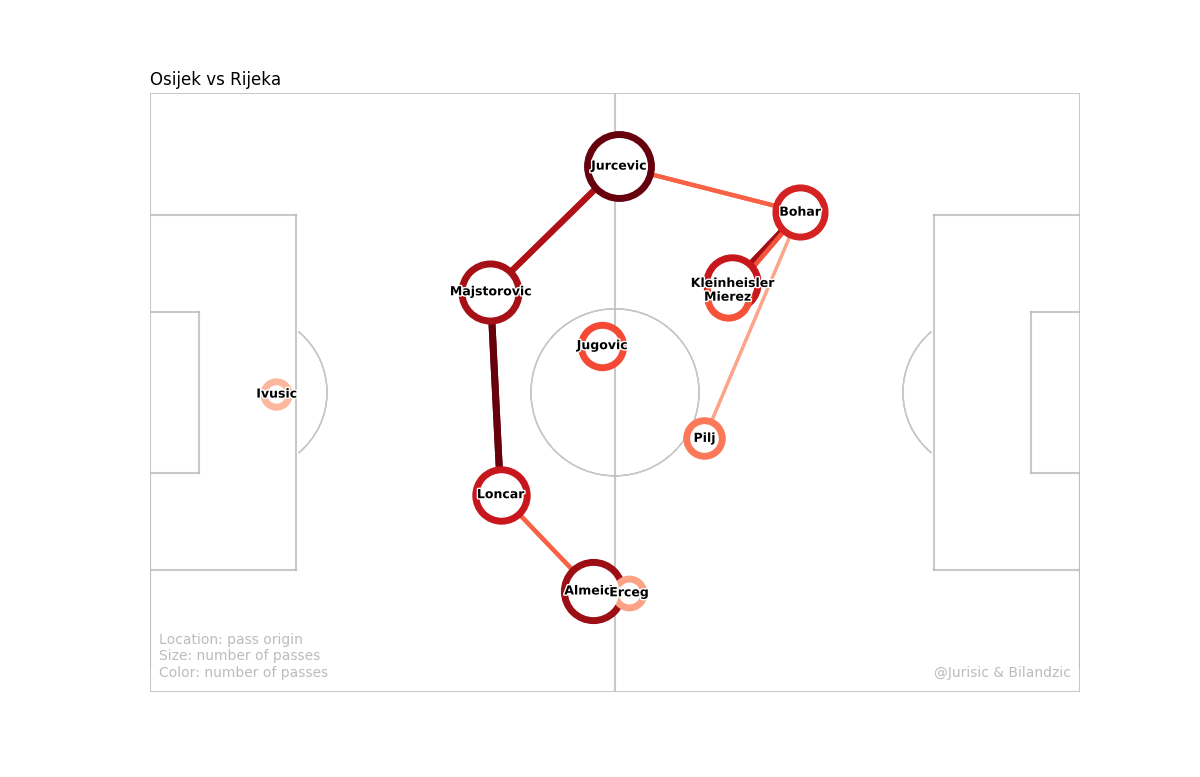

In [13]:
from IPython.display import Image
Image(file_img) 